In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance
import matplotlib.pyplot as plt

import trecs
from trecs.models import ImplicitMF, ImplicitMFLFD
from trecs.random import Generator
from trecs.metrics import MSEMeasurement, AverageFeatureScoreRange


In [9]:
mf = ImplicitMF(num_users=2000, num_items=500, num_latent_factors=20, num_items_per_iter=10)
mf.add_metrics(MSEMeasurement())
mf.add_metrics(AverageFeatureScoreRange())
mf.startup_and_train(20)
mf.run(timesteps=100, train_between_steps=True, reset_interactions=False)

100%|██████████| 20/20 [00:03<00:00,  6.31it/s]
/Users/amywinecoff/Documents/CITP/Research/Github/t-recs/trecs/models/mf.py:262: UserWarning: train_between_steps is set to True. Note that, at each step, this overwrites the MF model with a model fit only to the latest interaction. To avoid this behavior, set train_between_steps to False.
  "train_between_steps is set to True. Note that, at each step, this "
100%|██████████| 100/100 [01:41<00:00,  1.02s/it]


In [10]:
mflfd = ImplicitMFLFD(num_users=2000, num_items=500, num_latent_factors=20, num_items_per_iter=10)
mflfd.add_metrics(MSEMeasurement())
mflfd.add_metrics(AverageFeatureScoreRange())
mflfd.startup_and_train(20)
mflfd.run(timesteps=100, train_between_steps=True, reset_interactions=False)

100%|██████████| 100/100 [07:41<00:00,  4.62s/it]


In [11]:
mflfd_metrics = pd.DataFrame(mflfd.get_measurements())
mflfd_afsr= mflfd_metrics['afsr'].to_list()[21:]

mf_metrics = pd.DataFrame(mf.get_measurements())
mf_afsr= mf_metrics['afsr'].to_list()[21:]


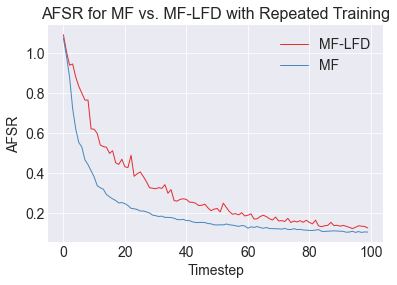

In [12]:
# style
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 14})

# create a color palette
palette = plt.get_cmap('Set1')

plt.plot(list(range(len(mflfd_afsr))), mflfd_afsr, marker='', color=palette(0), linewidth=1, alpha=0.9, label='MF-LFD')
plt.plot(list(range(len(mf_afsr))), mf_afsr, marker='', color=palette(1), linewidth=1, alpha=0.9, label='MF')

# Add legend
#plt.legend(loc=2, ncol=2)
plt.legend(loc=1, ncol=1)

# Add titles
plt.title("AFSR for MF vs. MF-LFD with Repeated Training", loc='center', fontsize=16, fontweight=2)
plt.xlabel("Timestep")
plt.ylabel("AFSR")
plt.show()



In [6]:
# top_n_limit=50
# k=10
# #self=mflfd

# def generate_recs(self, k=1, top_n_limit=None, item_indices=None):
    
#     if item_indices is not None:
#         if item_indices.size < self.num_users:
#             raise ValueError(
#                     "At least one user has interacted with all items!"
#                     "To avoid this problem, you may want to allow repeated items."
#                 )
#         if k > item_indices.shape[1]:
#             raise ValueError(
#                     f"There are not enough items left to recommend {k} items to each user."
#                 )
#         if k == 0:
#             return np.array([]).reshape((self.num_users, 0)).astype(int)
    
#     if not top_n_limit:
#         top_n_limit = self.items_hat.shape[1]       
        
#     row = np.repeat(self.users.user_vector, self.item_indices.shape[1])
#     row = row.reshape((self.num_users, -1))
#     s_filtered = self.predicted_scores[row, self.item_indices]

#     negated_scores = -1 * s_filtered  # negate scores so indices go from highest to lowest
#     # break ties using a random score component
#     scores_tiebreak = np.zeros(
#         negated_scores.shape, dtype=[("score", "f8"), ("random", "f8")]
#     )
#     scores_tiebreak["score"] = negated_scores
#     scores_tiebreak["random"] = self.random_state.random(negated_scores.shape)
#     top_k = scores_tiebreak.argpartition(top_n_limit - 1, order=["score", "random"])[:, :top_n_limit]
#     # now we sort within the top k
#     row = np.repeat(self.users.user_vector, top_n_limit).reshape((self.num_users, -1))
#     # again, indices should go from highest to lowest
#     sort_top_k = scores_tiebreak[row, top_k].argsort(order=["score", "random"])
#     top_k_recs = self.item_indices[row, top_k[row, sort_top_k]]

#     #dims are attribute, items, users
#     top_k_att = mflfd.items_hat[:, top_k_recs[:]].swapaxes(1,2)
    
#     rec = []
#     for idx, user in enumerate(mflfd.users_hat):

#             #make a copy so as not to modify the original array
#             user_item_feats = np.array(top_k_att[:,:,idx])

#             orig_user_item_feats = np.array(user_item_feats)
#             #user_item_feats_idx = [0]
#             user_max_idx = top_k_recs[idx, 0] 
#             recs_idxs = [user_max_idx]

#             #hold the features of the recommended items
#             recs_features = self.items_hat[:,user_max_idx]

#             for r in range(1,k):

#                 if r == 1:
#                     #for the second item, just use the first item values
#                     centroid = recs_features
#                 else:
#                     centroid = np.nanmean(recs_features, axis=0)

#                 centroid = centroid.reshape(1, -1)

#                 #set all the previously chosen item features to the centroid, so they will not be selected again
#                 #don't want to just remove rows because it will throw off the indexing
#                 user_item_feats[:, 0:r+1]=centroid.T

#                 d = pairwise_distances(X=centroid, Y=user_item_feats.T, metric='cityblock',force_all_finite='allow_nan' )

#                 most_distant = np.argmax(d)

#                 distances.append(d.max())

#                 most_distant_feats = user_item_feats.T[most_distant]

#                 #get the index of the most distant item in the top k recs
#                 recs_idxs.append(top_k_recs[idx, most_distant])
#                 recs_features = np.vstack((recs_features, user_item_feats[:, most_distant]))
#                 print (recs_idxs)
#             rec.append(recs_idxs)
    
#     return rec
